## Hugging Face datasets

In [1]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression


In [2]:
emotions_ds = load_dataset("emotion")

In [3]:
emotions_ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [4]:
train_ds = emotions_ds["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [5]:
print(train_ds[0])
print(train_ds.column_names)
print(train_ds.features)

{'text': 'i didnt feel humiliated', 'label': 0}
['text', 'label']
{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [6]:
emotions_ds.set_format("pandas")
train_df = emotions_ds["train"][:]
train_df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [7]:
train_ds.features['label'].names

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [8]:
train_df['label_name'] = train_df['label'].apply(lambda x: train_ds.features['label'].names[x])

In [9]:
train_df

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger
...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,sadness
15996,i am now turning and i feel pathetic that i am...,0,sadness
15997,i feel strong and good overall,1,joy
15998,i feel like this was such a rude comment and i...,3,anger


## Check the Data

Text(0, 0.5, 'Emotion')

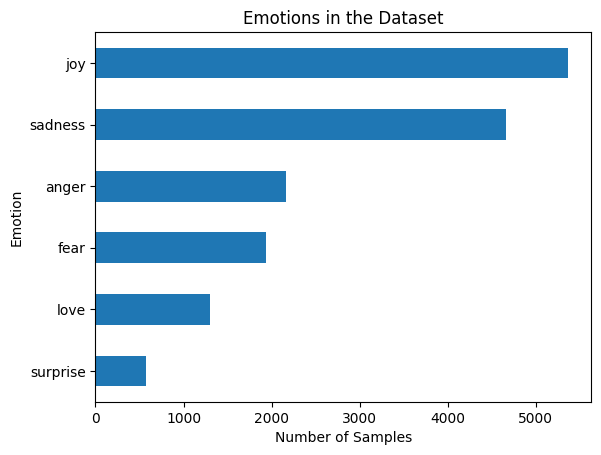

In [10]:
train_df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Emotions in the Dataset")
plt.xlabel("Number of Samples")
plt.ylabel("Emotion")

In [11]:
train_df["Words_per_tweet"] = train_df["text"].apply(lambda x: len(x.split()))

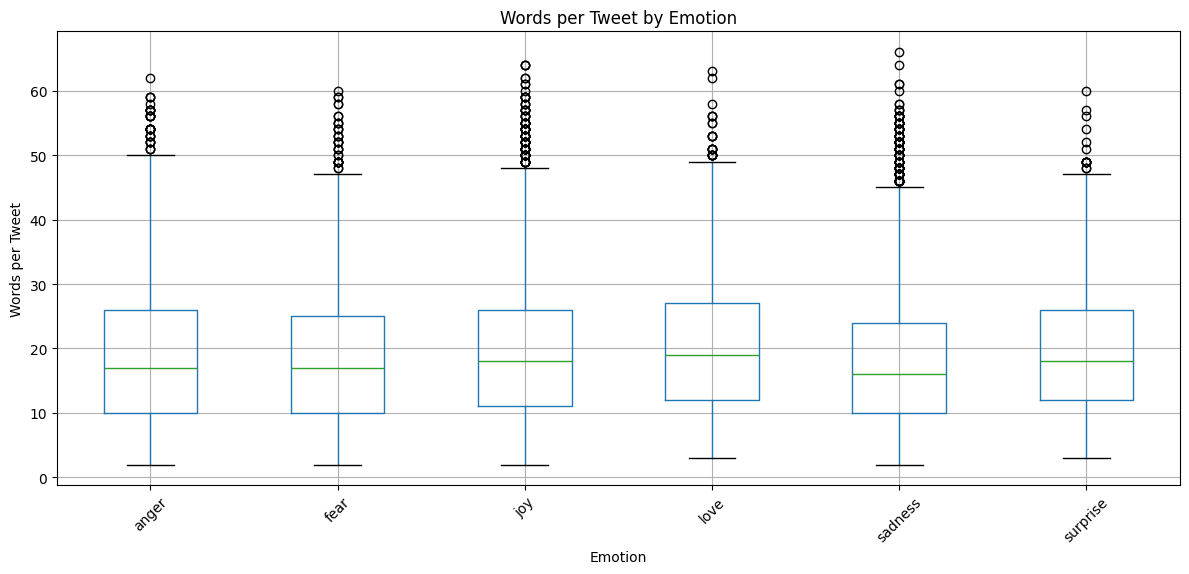

In [12]:
train_df.boxplot(column="Words_per_tweet", by="label_name", figsize=(12, 6))
plt.title("Words per Tweet by Emotion")
plt.suptitle("")
plt.xlabel("Emotion")
plt.ylabel("Words per Tweet")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [13]:
emotions_ds.reset_format()

## Tokenization

In [14]:
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)


In [15]:
tokenized_string=tokenizer("hello, how are you?")

In [16]:
tokenized_string

{'input_ids': [101, 7592, 1010, 2129, 2024, 2017, 1029, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [17]:
from transformers import DistilBertTokenizer
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [18]:
tokenized_string = distilbert_tokenizer("hello, how are you?")
print(tokenized_string)

{'input_ids': [101, 7592, 1010, 2129, 2024, 2017, 1029, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}


In [19]:
distilbert_tokenizer.convert_ids_to_tokens(tokenized_string["input_ids"])


['[CLS]', 'hello', ',', 'how', 'are', 'you', '?', '[SEP]']

In [20]:
distilbert_tokenizer.vocab_size

30522

In [21]:
distilbert_tokenizer.model_max_length

512

In [22]:
distilbert_tokenizer.model_input_names

['input_ids', 'attention_mask']

## Tokenize the whole dataset

In [23]:
def tokenize(batch):
    return distilbert_tokenizer(batch["text"], padding=True, truncation=True)

In [24]:
print(tokenize(emotions_ds["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [25]:
emotions_ds_encoded = emotions_ds.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [26]:
print(emotions_ds_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


## Training a Text Classifier

In [27]:
from transformers import AutoModel

In [28]:
model_ckpt = "distilbert-base-uncased"
device = "cpu"
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [29]:
text = "this is a test"
inputs = distilbert_tokenizer(text, return_tensors="pt")
print("Input tensor shape:", inputs["input_ids"].size())

Input tensor shape: torch.Size([1, 6])


In [30]:
print("inputs:", inputs)

inputs: {'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}


In [31]:
inputs = {k: v.to(device) for k, v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print("Output tensor:", outputs)
print("Output tensor shape:", outputs.last_hidden_state.size())

Output tensor: BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]]), hidden_states=None, attentions=None)
Output tensor shape: torch.Size([1, 6, 768])


In [32]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [33]:
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k,v in batch.items() if k in distilbert_tokenizer.model_input_names}
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}

In [34]:
emotions_ds_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [35]:
emotions_ds_hidden = emotions_ds_encoded.map(
    extract_hidden_states,
    batched=True,
)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [36]:
emotions_ds_hidden['train'].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [37]:
X_train = np.array(emotions_ds_hidden['train']['hidden_state'])
X_valid = np.array(emotions_ds_hidden['validation']['hidden_state'])
y_train = np.array(emotions_ds_hidden['train']['label'])
y_valid = np.array(emotions_ds_hidden['validation']['label'])
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

/var/folders/n2/j3zn2lg95d39cr9q6k6f6m4m0000gp/T/ipykernel_98232/3779375978.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  X_train = np.array(emotions_ds_hidden['train']['hidden_state'])
/var/folders/n2/j3zn2lg95d39cr9q6k6f6m4m0000gp/T/ipykernel_98232/3779375978.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  X_valid = np.array(emotions_ds_hidden['validation']['hidden_state'])
/var/folders/n2/j3zn2lg95d39cr9q6k6f6m4m0000gp/T/ipykernel_98232/3779375978.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  y_train = np.array(emotions_ds_hidden['train']['label'])
/var/folders/n2/j3zn2lg95d39cr9q6k6f6m4m0000gp/T/ip

((16000, 768), (2000, 768), (16000,), (2000,))

In [38]:
#scale the data
X_scaled = MinMaxScaler().fit_transform(X_train)
#initalize UMAP
mapper = UMAP(n_components=2, metric='cosine').fit(X_scaled)
df_emb = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])
df_emb['label'] = y_train
df_emb.head()


,X,Y,label
0,4.174349,3.724660,0
1,-3.330516,4.844871,0
2,5.426481,7.227003,3
3,-2.304597,6.763083,2
4,-3.406228,6.820422,3


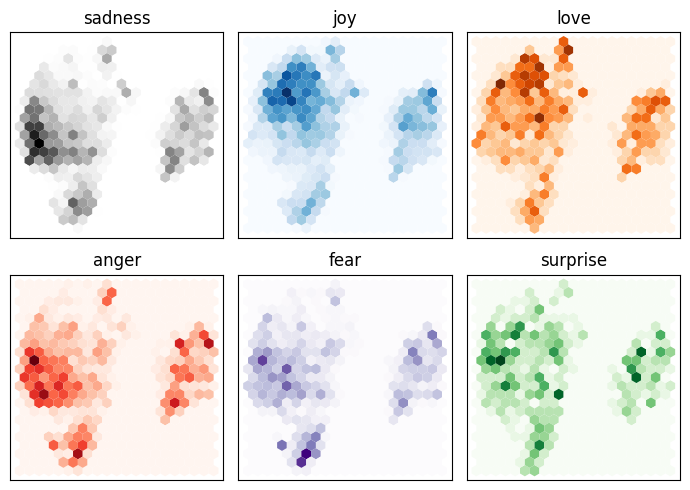

In [39]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions_ds["train"].features["label"].names
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])
plt.tight_layout()
plt.show()

In [40]:
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
print("Training accuracy:", lr_clf.score(X_train, y_train))
print("Validation accuracy:", lr_clf.score(X_valid, y_valid))

Training accuracy: 0.6945625
Validation accuracy: 0.6345


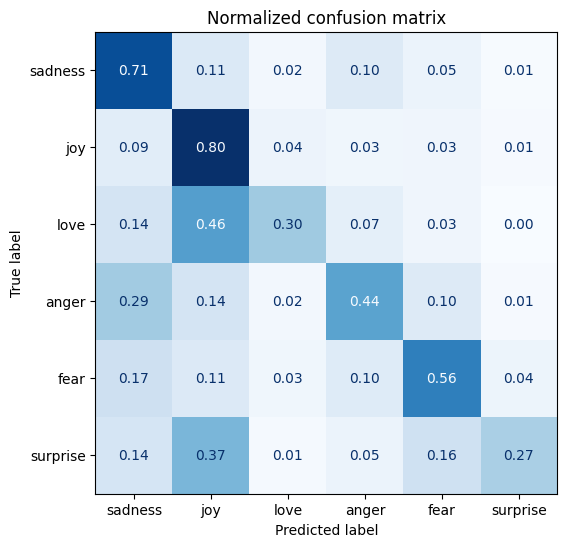

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

In [42]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels)
          .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "f1": f1,
    }

In [44]:
from huggingface_hub import notebook_login
notebook_login()

In [45]:
from transformers import Trainer, TrainingArguments
batch_size = 64
logging_steps = len(emotions_ds_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
num_train_epochs=2,
learning_rate=2e-5,
per_device_train_batch_size=batch_size,
per_device_eval_batch_size=batch_size,
weight_decay=0.01,
disable_tqdm=False,
logging_steps=logging_steps,
push_to_hub=True,
log_level="error")

In [46]:
trainer = Trainer(model=model, args=training_args,
compute_metrics=compute_metrics,
train_dataset=emotions_ds_encoded["train"],
eval_dataset=emotions_ds_encoded["validation"],
tokenizer=tokenizer)
trainer.train();

/var/folders/n2/j3zn2lg95d39cr9q6k6f6m4m0000gp/T/ipykernel_98232/4288775349.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,
/Users/shubhams/BAUHAUS/Learning/nlp_with_transformers/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
250,0.816200
500,0.244000


In [47]:
preds_output = trainer.predict(emotions_ds_encoded["validation"])

/Users/shubhams/BAUHAUS/Learning/nlp_with_transformers/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [48]:
preds_output.metrics

{'test_loss': 0.21197061240673065,
 'test_accuracy': 0.9275,
 'test_f1': 0.9275328809583021,
 'test_runtime': 13.1536,
 'test_samples_per_second': 152.049,
 'test_steps_per_second': 2.433}

In [49]:
y_preds = np.argmax(preds_output.predictions, axis=1)

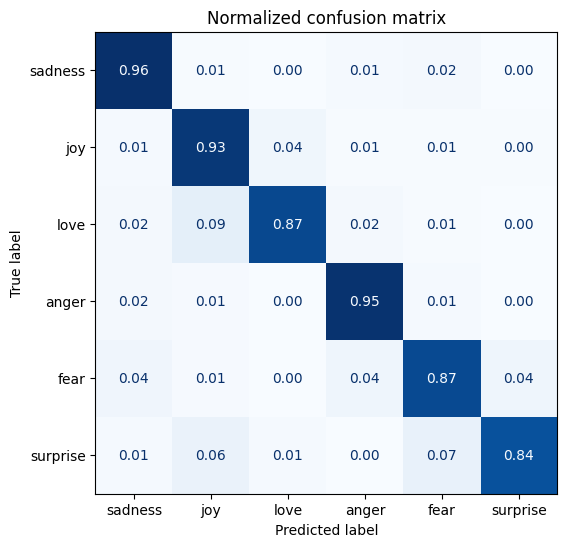

In [50]:
plot_confusion_matrix(y_preds, y_valid, labels)

In [57]:
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [65]:
from torch.nn.functional import cross_entropy

def forward_pass_with_labels(batch):
    inputs = {k: v.to(device) for k, v in batch.items() if k in distilbert_tokenizer.model_input_names}
    with torch.no_grad():   
        outputs = model(**inputs)
        pred_label = outputs.logits.argmax(axis=-1)
        loss = cross_entropy(outputs.logits, batch["label"].to(device), reduction="none")
    return {"loss": loss.cpu().numpy(), "predicted_label": pred_label.cpu().numpy()}

In [66]:
device

'cpu'

In [67]:
emotions_ds_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
emotions_ds_encoded["validation"] = emotions_ds_encoded["validation"].map(
    forward_pass_with_labels,
    batched=True,
    batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [71]:
def label_int2str(row):
    return emotions_ds["train"].features["label"].int2str(row)

In [75]:
emotions_ds_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_ds_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = df_test["predicted_label"].apply(label_int2str)

In [76]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
882,i feel badly about reneging on my commitment t...,love,sadness,5.429807
1950,i as representative of everything thats wrong ...,surprise,sadness,5.380060
1963,i called myself pro life and voted for perry w...,joy,sadness,5.271167
1500,i guess we would naturally feel a sense of lon...,anger,sadness,4.948560
1111,im lazy my characters fall into categories of ...,joy,fear,4.732602
1683,i had applied for a job and they had assured m...,anger,joy,4.580038
1509,i guess this is a memoir so it feels like that...,joy,fear,4.554899
1870,i guess i feel betrayed because i admired him ...,joy,sadness,4.498902
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.267185
1836,i got a very nasty electrical shock when i was...,fear,anger,4.226079


In [77]:
df_test.sort_values(by="loss", ascending=True).head(10)

,text,label,predicted_label,loss
131,i feel like a graph doesnt show the data accur...,joy,joy,0.017200
1873,i feel practically virtuous this month i have ...,joy,joy,0.017573
1205,i log on feeling vaguely sociable and after a ...,joy,joy,0.018106
578,i got to christmas feeling positive about the ...,joy,joy,0.018253
1780,ive explained that he is very creative and lov...,joy,joy,0.018451
1418,i am a big believer in the phrase that some pe...,joy,joy,0.018570
1523,i dont give a fuck because i feel like i canno...,joy,joy,0.018646
620,i shall move right along to the post interview...,joy,joy,0.018714
802,i hate hate hate watching people work and me s...,joy,joy,0.018781
1524,i wrote this article because if the extroverts...,joy,joy,0.018815


In [78]:
trainer.push_to_hub(commit_message="End of training")

Uploading...:   0%|          | 0.00/268M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ShubhamShubham/distilbert-base-uncased-finetuned-emotion/commit/3019f4d703a002ef3f2ff9153ad45f8cbbd3a41b', commit_message='End of training', commit_description='', oid='3019f4d703a002ef3f2ff9153ad45f8cbbd3a41b', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ShubhamShubham/distilbert-base-uncased-finetuned-emotion', endpoint='https://huggingface.co', repo_type='model', repo_id='ShubhamShubham/distilbert-base-uncased-finetuned-emotion'), pr_revision=None, pr_num=None)